In [1]:
## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2023-08-17 00:31:24.061653: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-17 00:31:29.802827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

2.12.0


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [2]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Cargar Dataset 

In [3]:
### Rutas
classes = ['CuNi1','CuNi2','CuNi3']
route_img = []
labels = []
cls = []


for clss in classes:
    cnt = 0
    route = ('../Datasets/Confocales_procesadas/recortadas1/'+clss+"/*.jpg")
    path = glob.glob(route) 
    for img in path:
        #print(img)
        route_img.append(img)    
        #labels.append(img)
        cls.append(clss)
        cnt = cnt +1;


images_df = pd.DataFrame()
images_df['routes'] = route_img
images_df['label'] = cls
#images_df['classes'] = cls

## Conversión de etiquetas
char_to_num = {}
num_to_char = {}

i = 0
for name in classes:
  num_to_char[i] = name
  char_to_num[name] = str(i)
  i += 1

images_df['label'].replace(char_to_num,inplace=True)

In [4]:
char_to_num

{'CuNi1': '0', 'CuNi2': '1', 'CuNi3': '2'}

In [5]:
## Establecer el porcentaje de separación
thold = int(np.ceil(0.8 * len(images_df)/3))

## Separar por clases para entrenamiento
train_cu1 = images_df[images_df.label == '0'][0:thold]
train_cu2 = images_df[images_df.label == '1'][0:thold]
train_cu3 = images_df[images_df.label == '2'][0:thold]

## tomar las demás imágenes para test
test_cu1 = images_df[images_df.label == '0'][thold:]
test_cu2 = images_df[images_df.label == '1'][thold:]
test_cu3 = images_df[images_df.label == '2'][thold:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

### Data Augmentation

In [6]:
## Crear objetos transformadores
## Para entrenamiento
img_generator_training = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.15
)

# Para testing
img_generator_test = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True    
)

In [7]:
## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator= img_generator_training.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['CuNi1','CuNi2','CuNi3'],
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

## Para validación
valid_generator= img_generator_training.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['CuNi1','CuNi2','CuNi3'],
    subset="validation",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    color_mode ="grayscale",
    target_size=(128,128))

## Para testeo
test_generator= img_generator_test.flow_from_dataframe(
    dataframe=test_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['CuNi1','CuNi2','CuNi3'],
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    color_mode ="grayscale",
    target_size=(128,128))

Found 408 validated image filenames belonging to 3 classes.
Found 72 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.


### Split

In [8]:
x_train_expanded = []
y_train_expanded = []

x_test = []
y_test = []

batches = 50
cnt = 0;

for i in range(batches):
    
    x,y = train_generator.next()

    x_train_expanded.extend(x)
    y_train_expanded.extend(y)

for j in range(int(np.ceil(batches*0.2))):
    
    x,y = test_generator.next()

    x_test.extend(x)
    y_test.extend(y)

print(np.shape(x_train_expanded),np.shape(y_train_expanded))
print(np.shape(x_test), np.shape(y_test))

(2920, 128, 128, 1) (2920,)
(600, 128, 128, 1) (600,)


(128, 128, 1)
0.0 1.0


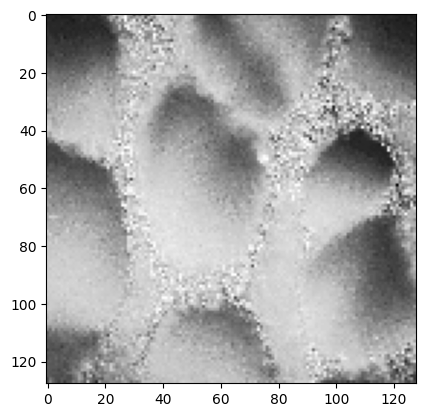

In [9]:
plt.imshow(x_train_expanded[0],cmap='gray')
print(np.shape(x_train_expanded[0]))
print(np.min(x_train_expanded[0]),np.max(x_train_expanded[0]))
plt.show()

In [10]:
x_train_expanded = np.array(x_train_expanded)
x_test = np.array(x_test)

x_train_expanded = x_train_expanded.astype('float32')
x_test= x_test.astype('float32')
 
#y_test = tf.keras.utils.to_categorical(y_test)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
#x_test /= 255

print('x_train shape:', x_train_expanded.shape)
print('Number of images in x_train', x_train_expanded.shape[0], "y_train:", np.shape(y_train_expanded))
print('Number of images in x_test', x_test.shape, "y_test: ", np.shape(y_test))

x_train shape: (2920, 128, 128, 1)
Number of images in x_train 2920 y_train: (2920,)
Number of images in x_test (600, 128, 128, 1) y_test:  (600,)


In [11]:
type(x_train_expanded)

numpy.ndarray

## Construir VAE 

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction /= tf.reduce_max(reconstruction)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            
            '''
            reconstruction_loss =tf.reduce_mean(
                tf.reduce_sum( tf.keras.losses.MeanSquaredError()(data, reconstruction)
                             )
            )
            '''
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))            
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.reconstruction = reconstruction
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)       
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),            
        }

#### Encoder

In [13]:
latent_dim = 128
nfilts = 512

encoder_inputs = keras.Input(shape=(128, 128,1))

x = tf.keras.layers.Conv2D(nfilts, (3, 3), activation='relu', padding='same',name='layer_E1')(encoder_inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/2, (3, 3), activation='relu', padding='same',name='layer_E3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/4, (3, 3), activation='relu', padding='same',name='layer_E2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

#x = tf.keras.layers.Conv2D(nfilts/4, (3, 3), activation='relu', padding='same',name='layer_E4')(x)
#x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
#x = tf.keras.layers.BatchNormalization()(x)

#x = tf.keras.layers.Conv2D(nfilts/8, (3, 3), activation='relu', padding='same',name='layer_E6')(x)
#x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
#x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/8, (3, 3), activation='relu', padding='same',name='layer_E7')(x)
x = layers.Flatten()(x)



z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

2023-08-10 19:09:33.399657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4604 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:1a:00.0, compute capability: 7.5


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 layer_E1 (Conv2D)              (None, 128, 128, 51  5120        ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 512)  0           ['layer_E1[0][0]']               
                                                                                            

#### Decoder

In [14]:
## Entrada Z
latent_inputs = keras.Input(shape=(latent_dim,))

##dimensiones
ndim = 8
nfilts = 256

## anti-flatten de la última capa convolucional
x = layers.Dense(ndim * ndim * nfilts, activation="relu")(latent_inputs)

## Reshape para reconstruir la última convolucional
x = layers.Reshape((ndim,ndim, nfilts))(x)

## Capas convolucionales
x = tf.keras.layers.Conv2D(nfilts, (3, 3), activation='relu', padding='same',name='layer_D1')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/2, (3, 3), activation='relu', padding='same',name='layer_D2')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/4, (3, 3), activation='relu', padding='same',name='layer_D4')(x)
x = tf.keras.layers.UpSampling2D((4, 4))(x)
x = tf.keras.layers.BatchNormalization()(x)

#x = tf.keras.layers.Conv2D(nfilts/, (3, 3), activation='relu', padding='same',name='layer_D3')(x)
#x = tf.keras.layers.UpSampling2D((2, 2))(x)
#x = tf.keras.layers.BatchNormalization()(x)

#x = tf.keras.layers.Conv2D(nfilts, (3, 3), activation='relu', padding='same',name='layer_D5')(x)
#x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/8, (3, 3), activation='relu', padding='same',name='layer_D6')(x)

decoder_outputs = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='layer_D7')(x)

## Construcción del decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 layer_D1 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                           

#### Entrenamiento

In [ ]:
vae = VAE(encoder, decoder)
opt = tf.optimizers.Adam(learning_rate = 0.000001)
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(x_train_expanded, epochs=2000, 
                batch_size=32,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)])

In [ ]:
vae.encoder.save('models2/VAE_3_encoder_64.h5')
vae.decoder.save('models2/VAE_3_decoder_64.h5')

## Generar Embebidos

### Cargar VAE

In [14]:
encoder = keras.models.load_model('../Notebooks_maestria/VAEs/models/VAE_1_encoder_128.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('../Notebooks_maestria/VAEs/models/VAE_1_decoder_128.h5', custom_objects={'Sampling':Sampling})

2023-08-17 00:36:41.745081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4816 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:1a:00.0, compute capability: 7.5


#### Reconstrucción (Entrenamiento)

In [15]:
# Embebidos del encoder
encoder_embds  = encoder.predict(x_train_expanded)
print('Shape_embs: ',np.shape(encoder_embds))

2023-08-17 00:36:49.162295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-17 00:36:53.730572: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-17 00:36:55.186916: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


92/92 [==============================] - 16s 74ms/step
Shape_embs:  (3, 2920, 128)


In [16]:
## Media = 0, Varianza = 1, Z = 2
D = 0

## Dimensiones
dmx = 16
dmy = 8

In [17]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs = decoder.predict(encoder_embds[D])
print(np.shape(autoencoder_imgs),np.shape(encoder_embds))

92/92 [==============================] - 2s 13ms/step
(2920, 128, 128, 1) (3, 2920, 128)


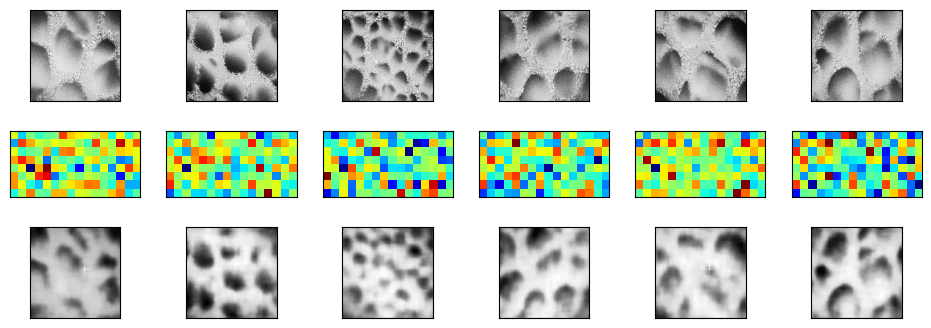

In [18]:
plt.figure(figsize=(40, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_train_expanded[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoder_embds[1][i].reshape(dmy,dmx),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

### PCA (training)

In [19]:
pca_data = PCA(n_components=3)
PCA_2dim = pca_data.fit_transform(encoder_embds[D])
PCA_2dim.shape

(2920, 3)

In [20]:
labels_text = pd.DataFrame(y_train_expanded).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text.shape

(2920, 1)

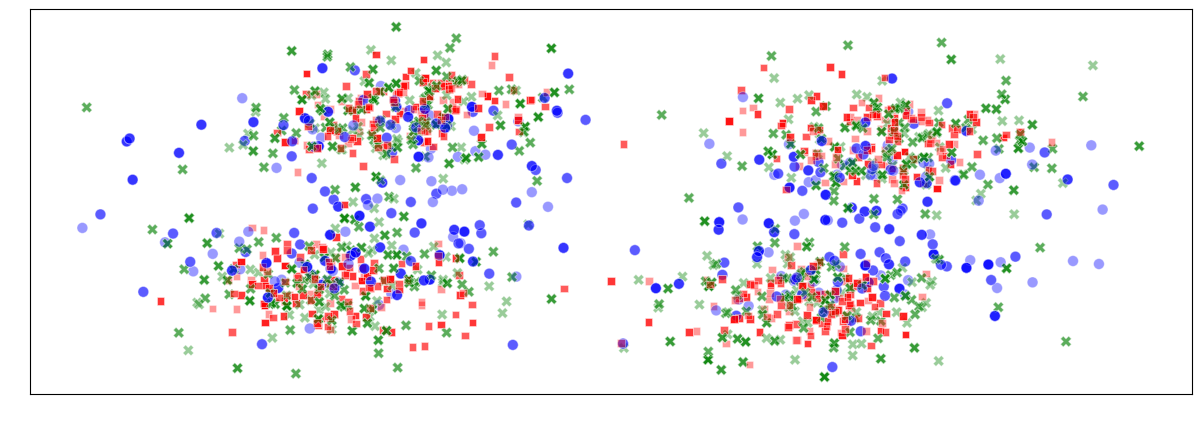

In [21]:
data_img = pd.DataFrame()                 
data_img['x'] = PCA_2dim[:,0]
data_img['y'] = PCA_2dim[:,1]
data_img['label'] = pd.DataFrame(labels_text)


plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img.x,y=data_img.y,hue='label',data=data_img, style='label',
            sizes=(60, 100), alpha=0.4, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=False, size = 2)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks([])
plt.yticks([])
#plt.legend(fontsize="18")
#plt.xticks(range(-5, 5))
#plt.grid()

plt.show()

11 3.70643 0.65928954 MF1


/tmp/ipykernel_8191/1781456479.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img[data_img.x > x][data_img.y > y][data_img.label == clase].x.values[0]
/tmp/ipykernel_8191/1781456479.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img[data_img.x > x][data_img.y > y][data_img.label == clase].x.values[0]
/tmp/ipykernel_8191/1781456479.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img[data_img.x > x][data_img.y > y][data_img.label == clase].y.values[0]
/tmp/ipykernel_8191/1781456479.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img[data_img.x > x][data_img.y > y][data_img.label == clase].y.values[0]
/tmp/ipykernel_8191/1781456479.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index = data_img[data_img.x > x][data_img.y > y][data_img.label == clase].index.values[0

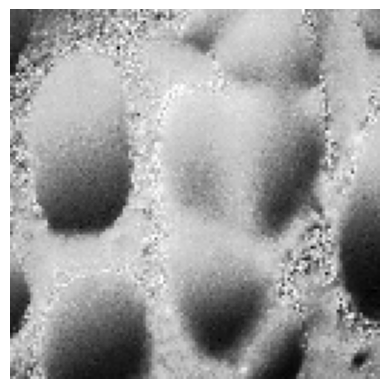

In [22]:
##Recuperar una imágen
x = 0
y = 0

clase = 'MF1'

n_x = data_img[data_img.x > x][data_img.y > y][data_img.label == clase].x.values[0]

n_y = data_img[data_img.x > x][data_img.y > y][data_img.label == clase].y.values[0]

index = data_img[data_img.x > x][data_img.y > y][data_img.label == clase].index.values[0]


print(index,n_x,n_y,clase)

## Recuperar imágen 
original = x_train_expanded[index].reshape(128,128,1)
reconstructed = autoencoder_imgs[i].reshape(128,128,1)

plt.imshow(original)
plt.axis('off')
#plt.imshow(reconstructed)
plt.show()

/tmp/ipykernel_8191/2958147927.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].x.values[0]


1 2.2224584 -2.4010026 MF2


/tmp/ipykernel_8191/2958147927.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].x.values[0]
/tmp/ipykernel_8191/2958147927.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].y.values[0]
/tmp/ipykernel_8191/2958147927.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].y.values[0]
/tmp/ipykernel_8191/2958147927.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].index.values[0]
/tmp/ipykernel_8191/2958147927.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].index.val

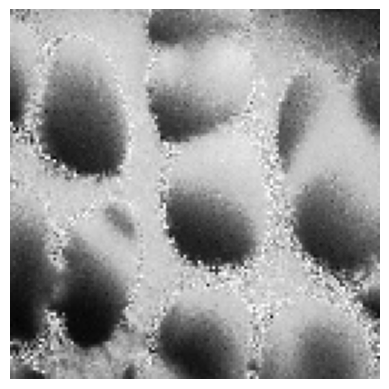

In [23]:
clase = 'MF2'

n_x = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].x.values[0]

n_y = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].y.values[0]

index = data_img[data_img.x > x][data_img.y < y][data_img.label == clase].index.values[0]


print(index,n_x,n_y,clase)

## Recuperar imágen 
original = x_train_expanded[index].reshape(128,128,1)
reconstructed = autoencoder_imgs[i].reshape(128,128,1)

plt.imshow(original)
plt.axis('off')
#plt.imshow(reconstructed)
plt.show()

17 -1.5823169 -1.076802 MF2


/tmp/ipykernel_8191/3273353748.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img[data_img.x < x][data_img.y < y][data_img.label == clase].x.values[0]
/tmp/ipykernel_8191/3273353748.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img[data_img.x < x][data_img.y < y][data_img.label == clase].x.values[0]
/tmp/ipykernel_8191/3273353748.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img[data_img.x < x][data_img.y < y][data_img.label == clase].y.values[0]
/tmp/ipykernel_8191/3273353748.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img[data_img.x < x][data_img.y < y][data_img.label == clase].y.values[0]
/tmp/ipykernel_8191/3273353748.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index = data_img[data_img.x < x][data_img.y < y][data_img.label == clase].index.values[0]

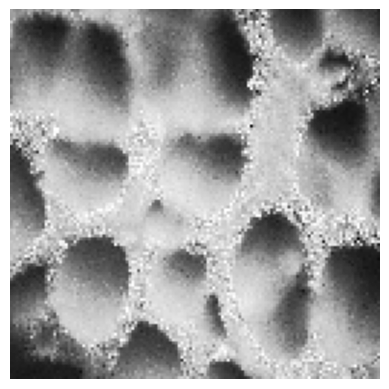

In [24]:
clase = 'MF2'

n_x = data_img[data_img.x < x][data_img.y < y][data_img.label == clase].x.values[0]

n_y = data_img[data_img.x < x][data_img.y < y][data_img.label == clase].y.values[0]

index = data_img[data_img.x < x][data_img.y < y][data_img.label == clase].index.values[0]


print(index,n_x,n_y,clase)

## Recuperar imágen 
original = x_train_expanded[index].reshape(128,128,1)
reconstructed = autoencoder_imgs[i].reshape(128,128,1)

plt.imshow(original)
plt.axis('off')
#plt.imshow(reconstructed)
plt.show()

/tmp/ipykernel_8191/4230816067.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].x.values[0]
/tmp/ipykernel_8191/4230816067.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].x.values[0]


8 -2.1842217 2.2919865 MF2


/tmp/ipykernel_8191/4230816067.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].y.values[0]
/tmp/ipykernel_8191/4230816067.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].y.values[0]
/tmp/ipykernel_8191/4230816067.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].index.values[0]
/tmp/ipykernel_8191/4230816067.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].index.values[0]


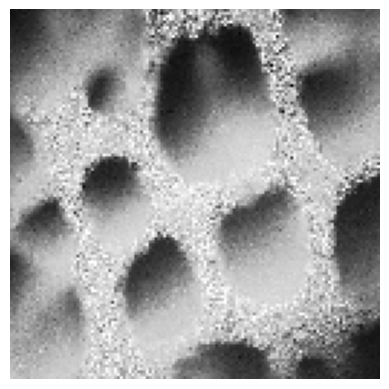

In [25]:
n_x = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].x.values[0]

n_y = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].y.values[0]

index = data_img[data_img.x < x][data_img.y > y][data_img.label == clase].index.values[0]


print(index,n_x,n_y,clase)

## Recuperar imágen 
original = x_train_expanded[index].reshape(128,128,1)
reconstructed = autoencoder_imgs[i].reshape(128,128,1)

plt.imshow(original)
plt.axis('off')
#plt.imshow(reconstructed)
plt.show()

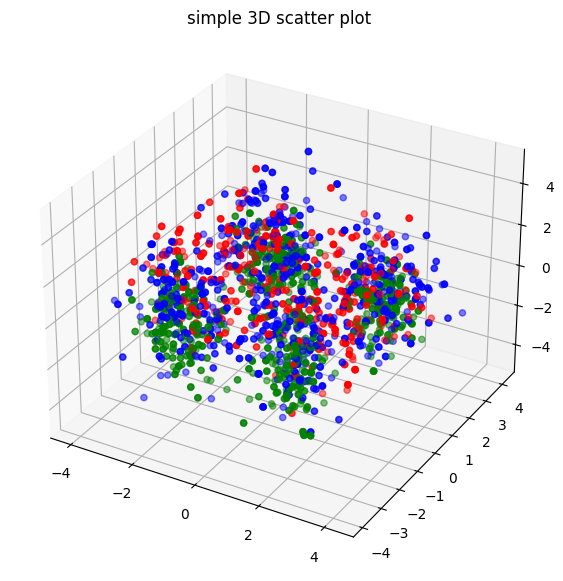

In [26]:
from mpl_toolkits import mplot3d
data_img = pd.DataFrame()                 
data_img['x'] = PCA_2dim[:,0]
data_img['y'] = PCA_2dim[:,1]
data_img['z'] = PCA_2dim[:,2]
data_img['label'] = pd.DataFrame(labels_text)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(data_img.x,data_img.y,data_img.z,data=data_img,alpha=0.5,
            c=data_img.label.map({'MF1':'r','MF2':'b','MF3':'g'}))
plt.title("simple 3D scatter plot")

#plt.grid()
plt.show()

### LDA (training)

In [27]:
lda_2dim = LDA(n_components=2).fit_transform(encoder_embds[D],labels_text)
lda_2dim.shape

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2920, 2)

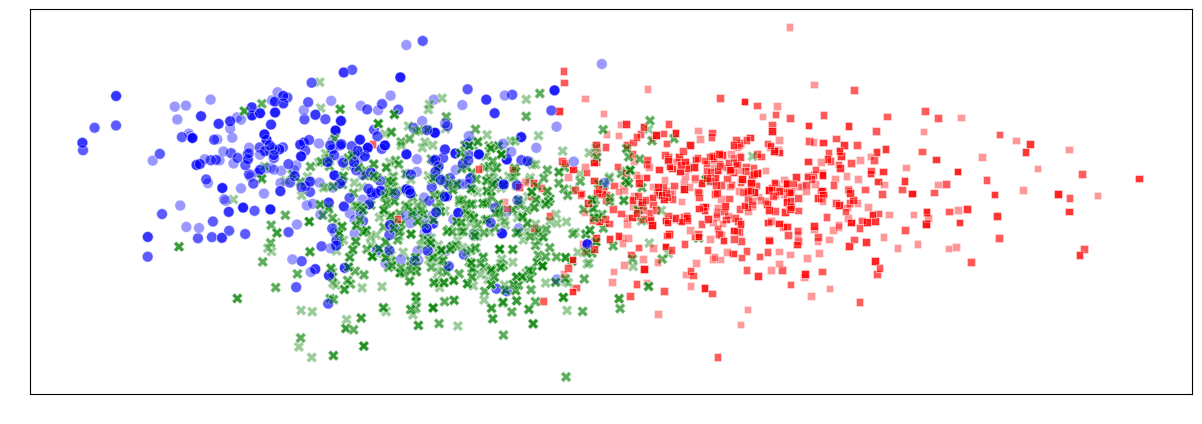

In [28]:
lda_data_img = pd.DataFrame()                 
lda_data_img['x'] = lda_2dim[:,0]
lda_data_img['y'] = lda_2dim[:,1]
lda_data_img['label'] = pd.DataFrame(labels_text)

plt.figure(figsize=(15,5))
sns.scatterplot(x=lda_data_img.x,y=lda_data_img.y,hue=lda_data_img.label,data=lda_data_img,style='label',
            sizes=(60, 100), alpha=0.4, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=False, size = 2)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks([])
plt.yticks([])
#plt.legend(fontsize="18")
#plt.xticks(range(-6, 8,1))
#plt.yticks(range(-6, 6,1))
#plt.grid()
plt.show()

### Embebidos para testing

In [29]:
encoder_embds_test  = encoder.predict(x_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

19/19 [==============================] - 2s 136ms/step
Shape_embs:  (3, 600, 128)


In [30]:
autoencoder_imgs_test = decoder.predict(encoder_embds_test[D])
print(np.shape(autoencoder_imgs_test),np.shape(encoder_embds_test))

19/19 [==============================] - 1s 37ms/step
(600, 128, 128, 1) (3, 600, 128)


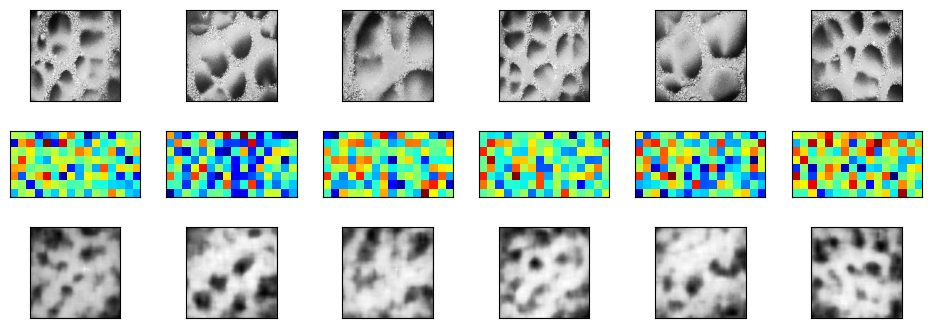

In [31]:
plt.figure(figsize=(40, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoder_embds_test[1][i].reshape(dmy,dmx),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

In [32]:
labels_text_test = pd.DataFrame(y_test).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text_test.shape

(600, 1)

In [33]:
lda_2dim = LDA(n_components=2).fit_transform(encoder_embds_test[D],labels_text_test)
lda_2dim.shape

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(600, 2)

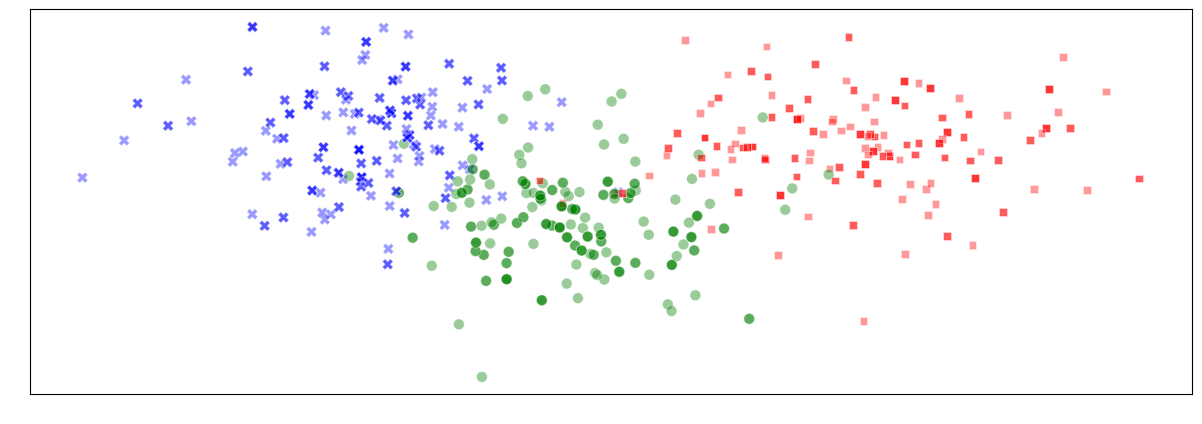

In [34]:
lda_data_img = pd.DataFrame()                 
lda_data_img['x'] = lda_2dim[:,0]
lda_data_img['y'] = lda_2dim[:,1]
lda_data_img['label'] = pd.DataFrame(labels_text_test)

plt.figure(figsize=(15,5))
sns.scatterplot(x=lda_data_img.x,y=lda_data_img.y,hue=lda_data_img.label,data=lda_data_img,style='label',
            sizes=(60, 100), alpha=0.4, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=False, size = 2)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks([])
plt.yticks([])
plt.show()

### PCA testing

In [35]:
pca_data = PCA(n_components=2)
PCA_2dim = pca_data.fit_transform(encoder_embds_test[D])
PCA_2dim.shape

(600, 2)

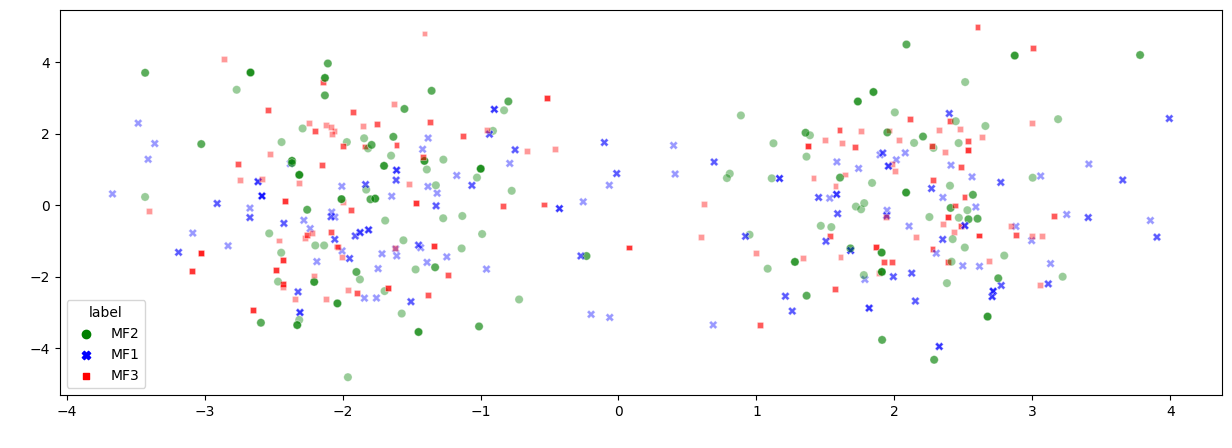

In [44]:
data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim[:,0]
data_img_pca_test['y'] = PCA_2dim[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,style='label',
            sizes=(60, 100), alpha=0.4, palette={"MF3": "red", "MF2": "green", "MF1": "blue"})
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

3 -1.8743443 -2.0811868 MF2


/tmp/ipykernel_8191/1287022399.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img_pca_test[data_img_pca_test.x < x][data_img_pca_test.y < y][data_img_pca_test.label == clase].x.values[number]
/tmp/ipykernel_8191/1287022399.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_x = data_img_pca_test[data_img_pca_test.x < x][data_img_pca_test.y < y][data_img_pca_test.label == clase].x.values[number]
/tmp/ipykernel_8191/1287022399.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img_pca_test[data_img_pca_test.x < x][data_img_pca_test.y < y][data_img_pca_test.label == clase].y.values[number]
/tmp/ipykernel_8191/1287022399.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_y = data_img_pca_test[data_img_pca_test.x < x][data_img_pca_test.y < y][data_img_pca_test.label == clase].y.values[number]
/tmp/ipykernel_8191/1287022399.py:13: 

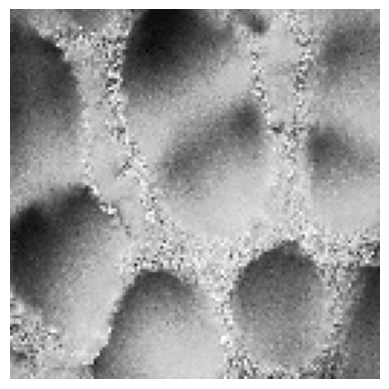

In [46]:
data_img.x ##Recuperar una imágen
x = 0
y = 0

number = 1

clase = 'MF2'

n_x = data_img_pca_test[data_img_pca_test.x < x][data_img_pca_test.y < y][data_img_pca_test.label == clase].x.values[number]

n_y = data_img_pca_test[data_img_pca_test.x < x][data_img_pca_test.y < y][data_img_pca_test.label == clase].y.values[number]

index = data_img_pca_test[data_img_pca_test.x < x][data_img_pca_test.y < y][data_img_pca_test.label == clase].index.values[number]


print(index,n_x,n_y,clase)

## Recuperar imágen 
original = x_train_expanded[index].reshape(128,128,1)
reconstructed = autoencoder_imgs[index].reshape(128,128,1)

plt.imshow(original)
plt.axis('off')
#plt.imshow(reconstructed)
plt.show()

## MÉTRICAS DE CLASIFICACIÓN

### Datos (Embebidos)

In [45]:
char_to_num_new = {'MF1':0,'MF2':1,'MF3':2}
char_to_num_new

{'MF1': 0, 'MF2': 1, 'MF3': 2}

In [46]:
## Embebidos
#--- Train
media_train = encoder_embds[0]
variance_train = encoder_embds[1]
z_train = encoder_embds[2]

#--- Test
media_test = encoder_embds_test[0]
variance_test = encoder_embds_test[1]
z_test = encoder_embds_test[2]

#--- labels
#labels_text_test
#labels_text
#images_df['label'].replace(char_to_num,inplace=True)

data_embs_train = pd.DataFrame()
data_embs_train ['mean'] =  media_train.tolist()
data_embs_train ['var'] =  variance_train.tolist()
data_embs_train ['z'] =  z_train.tolist()
data_embs_train ['labels'] = labels_text[0].replace(char_to_num_new)

data_embs_test = pd.DataFrame()
data_embs_test ['mean'] =  media_test.tolist()
data_embs_test ['var'] =  variance_test.tolist()
data_embs_test ['z'] =  z_test.tolist()
data_embs_test ['labels'] = labels_text_test[0].replace(char_to_num_new)


data_embs_test

mean   
0    [-0.47028011083602905, -1.2011994123458862, 0....  \
1    [0.5336942076683044, -0.7986703515052795, 0.07...   
2    [1.6847003698349, -0.4053085744380951, 0.36097...   
3    [0.5489920377731323, -0.6119102835655212, -0.5...   
4    [0.6325824856758118, 0.5749227404594421, 2.036...   
..                                                 ...   
595  [0.47022655606269836, -0.262168288230896, 1.78...   
596  [-1.7555562257766724, 0.947020411491394, -0.43...   
597  [0.24548092484474182, 1.127930760383606, -0.83...   
598  [0.4407403767108917, -0.16885115206241608, -0....   
599  [-0.9698382616043091, -0.6604897975921631, -0....   

                                                   var   
0    [-2.2964658737182617, -2.321556329727173, -2.4...  \
1    [-1.9900561571121216, -2.4846489429473877, -2....   
2    [-2.5443949699401855, -2.628573417663574, -2.2...   
3    [-2.511737585067749, -2.6166560649871826, -2.6...   
4    [-2.0581700801849365, -2.4660556316375732, -2....   
..                                                 ...   
595  [-2.0245347023010254, -2.550992488861084, -2.6...   
596  [-2.302046298980713, -3.4066104888916016, -2.9...   
597  [-2.4974067211151123, -2.5967726707458496, -2....   
598  [-2.2782013416290283, -3.0245614051818848, -2....   
599  [-2.3312556743621826, -2.810453176498413, -2.5...   

                                                     z  labels  
0    [-0.7571021914482117, -1.1804300546646118, 0.7...       1  
1    [0.14366689324378967, -0.6111016869544983, -0....       1  
2    [1.0600504875183105, -0.3987065553665161, 0.14...       0  
3    [0.9556092023849487, -0.5451223850250244, -0.6...       1  
4    [0.31270793080329895, 0.8955870866775513, 2.50...       0  
..                                                 ...     ...  
595  [1.1768852472305298, -0.5819089412689209, 1.91...       0  
596  [-1.8611998558044434, 0.8262328505516052, -0.4...       2  
597  [0.009162366390228271, 0.8682964444160461, -1....       0  
598  [0.8813547492027283, -0.0438460111618042, -0.0...       2  
599  [-1.028294563293457, -0.8945713639259338, -0.2...       1  

[600 rows x 4 columns]

### Decision Tree

#### Media

max:  0.8166666666666668
accuracy 0.797 (+/- 0.04069)


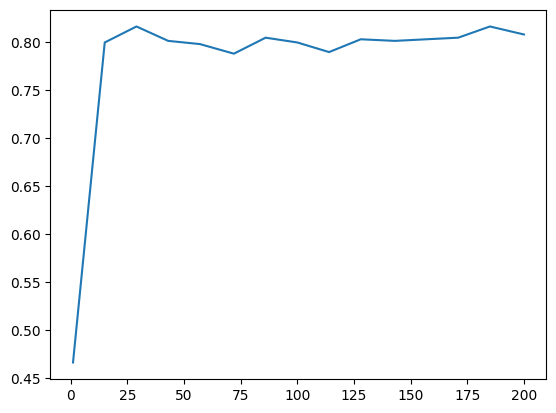

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *

dpst = []
acs = []

for d in np.linspace(1,200,15, dtype=int):
    est = DecisionTreeClassifier(max_depth=d)

    s = cross_val_score(est, list(data_embs_test['mean'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

est = DecisionTreeClassifier(max_depth=100)
s = cross_val_score(est, list(data_embs_test['mean'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

### Varianza

max:  0.9049999999999999
accuracy 0.875 (+/- 0.04845)


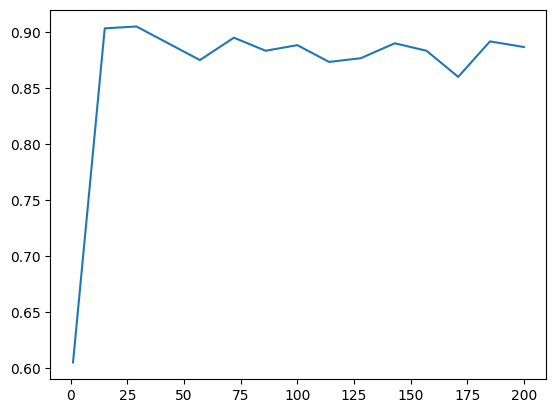

In [ ]:
dpst = []
acs = []

for d in np.linspace(1,200,15, dtype=int):
    est = DecisionTreeClassifier(max_depth=d)

    s = cross_val_score(est, list(data_embs_test['var'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

est = DecisionTreeClassifier(max_depth=100)
s = cross_val_score(est, list(data_embs_test['var'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

#### Z

max:  0.6366666666666667
accuracy 0.587 (+/- 0.06046)


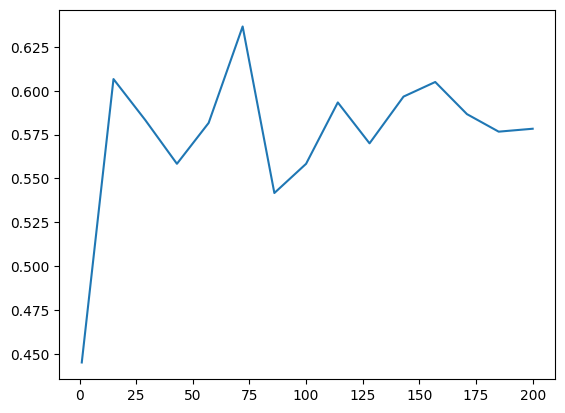

In [ ]:
dpst = []
acs = []

for d in np.linspace(1,200,15, dtype=int):
    est = DecisionTreeClassifier(max_depth=d)

    s = cross_val_score(est, list(data_embs_test['z'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

est = DecisionTreeClassifier(max_depth=100)
s = cross_val_score(est, list(data_embs_test['z'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

### RF

#### Media

max:  0.8749999999999998
accuracy 0.845 (+/- 0.05003)


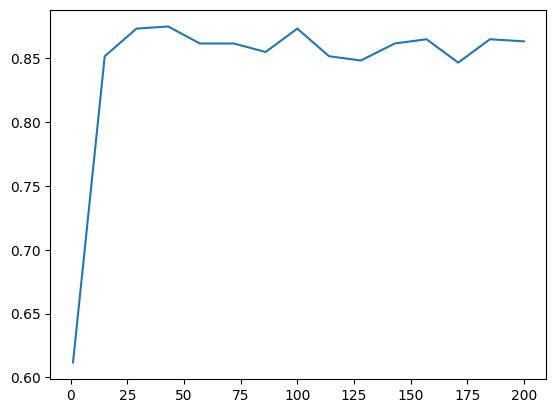

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


acs = []
dpst = []

for d in np.linspace(1,200,15, dtype=int):
    est = RandomForestClassifier(max_depth=d)

    s = cross_val_score(est, list(data_embs_test['mean'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

est = RandomForestClassifier()
s = cross_val_score(est, list(data_embs_test['mean'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()


#### Varianza

max:  0.9766666666666668
accuracy 0.955 (+/- 0.02587)


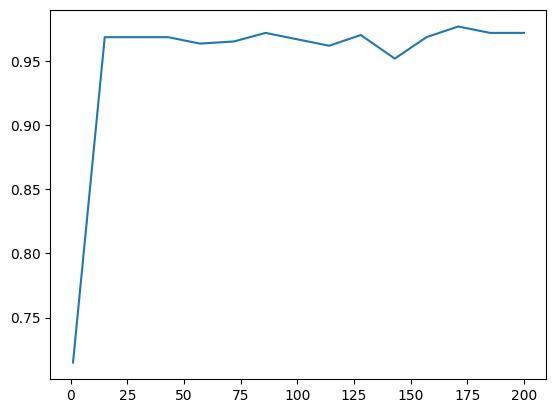

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

acs = []
dpst = []

for d in np.linspace(1,200,15, dtype=int):
    est = RandomForestClassifier(max_depth=d)

    s = cross_val_score(est, list(data_embs_test['var'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

est = RandomForestClassifier()
s = cross_val_score(est, list(data_embs_test['var'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

#### Z

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

acs = []
dpst = []

for d in np.linspace(1,200,15, dtype=int):
    est = RandomForestClassifier(max_depth=d)

    s = cross_val_score(est, list(data_embs_test['z'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

est = RandomForestClassifier()
s = cross_val_score(est, list(data_embs_test['z'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

KeyboardInterrupt: 

### KNN

#### Media

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scs = []
dst = []

for d in np.linspace(1,500,15, dtype=int):
    knn = KNeighborsClassifier(n_neighbors = d)

    knn.fit(list(data_embs_train['mean'].values),list(data_embs_train['labels'].values))

    y_pred = knn.predict(list(data_embs_test['mean'].values))

    #print("Accuracy: ", accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    scs.append(accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    dst.append(d)

print(np.max(scs))
plt.plot(dst,scs)    

#### Varianza

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scs = []
dst = []

for d in np.linspace(1,500,15, dtype=int):
    knn = KNeighborsClassifier(n_neighbors = d)

    knn.fit(list(data_embs_train['var'].values),list(data_embs_train['labels'].values))

    y_pred = knn.predict(list(data_embs_test['var'].values))

    #print("Accuracy: ", accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    scs.append(accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    dst.append(d)

print(np.max(scs))
print(dst[np.argmax(scs)])
plt.plot(dst,scs)   

#### Z

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scs = []
dst = []

for d in np.linspace(1,500,15, dtype=int):
    knn = KNeighborsClassifier(n_neighbors = d)

    knn.fit(list(data_embs_train['z'].values),list(data_embs_train['labels'].values))

    y_pred = knn.predict(list(data_embs_test['z'].values))

    #print("Accuracy: ", accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    scs.append(accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    dst.append(d)

print(np.max(scs))
plt.plot(dst,scs)  